# Ajuste de uma Série Temporal através de Redes Neurais

In [1]:
#Importe dos pacotes
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
#Leitura dos dados de treino
base = pd.read_csv('petr4_treinamento_ex.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:2].values

In [3]:
#Normalizando os dados
normalizador = MinMaxScaler(feature_range = (0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [4]:
#Construindo uma base utilizando como features os últimos 90 dias de observação
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [5]:
#Ajuste da Rede Neural

regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', 
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0279 - mean_absolute_error: 0.1225
Epoch 2/100
1152/1152 [==============================] - 10s 8ms/step - loss: 0.0109 - mean_absolute_error: 0.0829
Epoch 3/100
1152/1152 [==============================] - 10s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0733
Epoch 4/100
1152/1152 [==============================] - 10s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0690
Epoch 5/100
1152/1152 [==============================] - 10s 8ms/step - loss: 0.0074 - mean_absolute_error: 0.0649
Epoch 6/100
1152/1152 [==============================] - 10s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0610
Epoch 7/100
1152/1152 [==============================] - 11s 9ms/step - loss: 0.0057 - mean_absolute_error: 0.0589
Epoch 8/100
1152/1152 [==============================] - 11s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0564
Epoch 9/100
1152/1152 [==============================] - 11s 9ms/step - loss: 

In [6]:
#Leitura dos dados de teste
base_teste = pd.read_csv('petr4_teste_ex.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values

In [7]:
#Une os dados de treino e teste para montagem da base histórica e padroniza as variáveis
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [8]:
#Monta a base histórica para os dados de teste
X_teste = []
for i in range(90, 109):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

#previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [9]:
#Predita os dados de teste
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

In [10]:
#Compara as médias entre o predito e o real
print(previsoes.mean())
print(preco_real_teste.mean())

16.68396
16.379473684210524


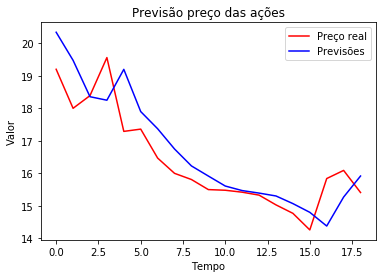

In [11]:
#Gráfico compartivo entre o real e o predito
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()